In [1]:
import pandas as pd
import numpy as np


In [11]:
# Load Dataset
df = pd.read_csv('retail_sales_dataset.csv')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# We fill missing days with 0 to represent 'No Sales'
daily_sales = df.groupby('Date')['Total Amount'].sum().resample('D').sum().fillna(0).to_frame()

In [12]:
# Feature Engineering: Temporal & Lag Features
def create_features(df):
    df = df.copy()
    df['day_of_week'] = df.index.dayofweek
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    df['month'] = df.index.month
    
    # Lag Features: What happened yesterday? What happened last week?
    df['lag_1'] = df['Total Amount'].shift(1)
    df['lag_7'] = df['Total Amount'].shift(7)
    
    # Rolling Windows: Capturing the recent trend (Moving Average)
    df['rolling_mean_7'] = df['Total Amount'].shift(1).rolling(window=7).mean()
    df['rolling_std_7'] = df['Total Amount'].shift(1).rolling(window=7).std()
    
    return df.dropna()

model_df = create_features(daily_sales)
print("Engineered Feature Set (First 5 rows):")
display(model_df.head())

Engineered Feature Set (First 5 rows):


,Total Amount,day_of_week,is_weekend,month,lag_1,lag_7,rolling_mean_7,rolling_std_7
Date,,,,,,,,
2023-01-08,625,6,1,1,150.0,3600.0,1296.428571,1141.974585
2023-01-09,200,0,0,1,625.0,1765.0,871.428571,533.015903
2023-01-10,230,1,0,1,200.0,600.0,647.857143,409.693556
2023-01-11,280,2,0,1,230.0,1240.0,595.000000,439.668436
2023-01-12,0,3,0,1,280.0,1100.0,457.857143,344.333379


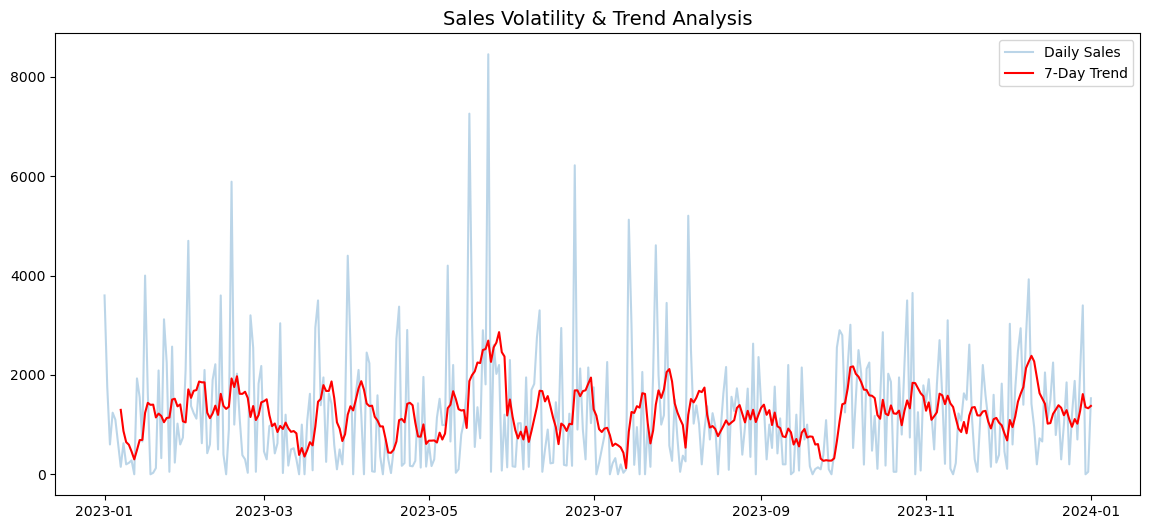

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visual 1: Monthly Trend with 7-Day Moving Average
plt.figure(figsize=(14, 6))
plt.plot(daily_sales.index, daily_sales['Total Amount'], alpha=0.3, label='Daily Sales')
plt.plot(daily_sales.index, daily_sales['Total Amount'].rolling(7).mean(), color='red', label='7-Day Trend')
plt.title('Sales Volatility & Trend Analysis', fontsize=14)
plt.legend()
plt.show()

In [14]:
# Visual 2: Category Contribution vs. Volume
cat_analysis = df.groupby('Product Category').agg({
    'Total Amount': 'sum',
    'Quantity': 'sum',
    'Transaction ID': 'count'
}).rename(columns={'Transaction ID': 'Order Count'})

# Identifying High-Value vs High-Volume categories
cat_analysis['Avg Order Value'] = cat_analysis['Total Amount'] / cat_analysis['Order Count']
display(cat_analysis.sort_values(by='Total Amount', ascending=False))

,Total Amount,Quantity,Order Count,Avg Order Value
Product Category,,,,
Electronics,156905,849,342,458.786550
Clothing,155580,894,351,443.247863
Beauty,143515,771,307,467.475570


--- Model Performance ---
Mean Absolute Error (MAE): $793.29
Root Mean Squared Error (RMSE): $975.21
Mean Absolute Percentage Error (MAPE): 12078557501444575232.00%


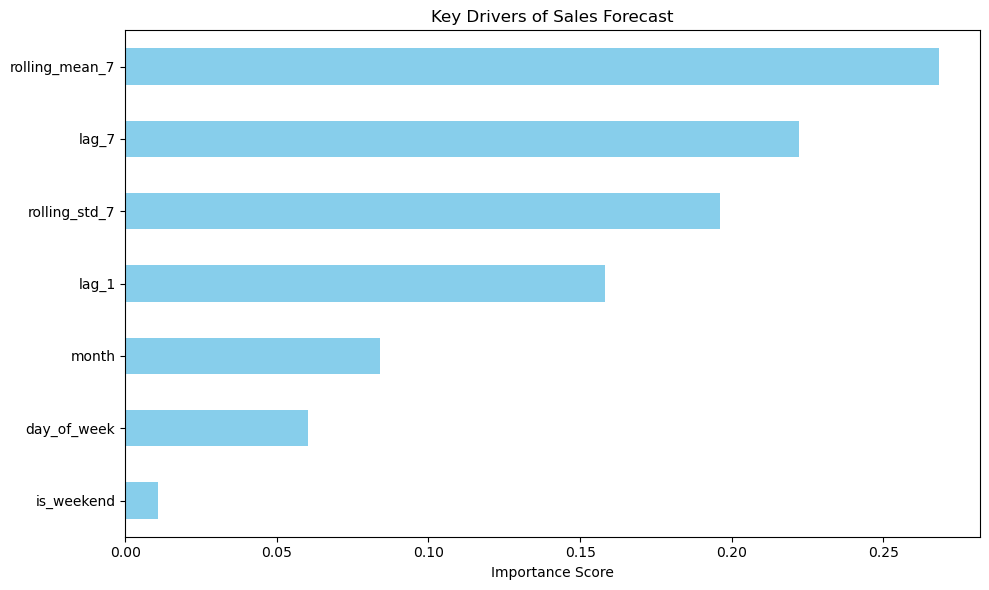

In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Time-Series Split for Last 30 days
train = model_df.iloc[:-30]
test = model_df.iloc[-30:]

X_train, y_train = train.drop('Total Amount', axis=1), train['Total Amount']
X_test, y_test = test.drop('Total Amount', axis=1), test['Total Amount']

# Model Init with Tuning
model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
model.fit(X_train, y_train)

preds = model.predict(X_test)

# Evaluation Metrics
mae = mean_absolute_error(y_test, preds)
rmse = np.sqrt(mean_squared_error(y_test, preds))
mape = mean_absolute_percentage_error(y_test, preds)

print(f"--- Model Performance ---")
print(f"Mean Absolute Error (MAE): ${mae:.2f}")
print(f"Root Mean Squared Error (RMSE): ${rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2%}")

plt.figure(figsize=(10, 6))
importances = pd.Series(model.feature_importances_, index=X_train.columns).sort_values()
importances.plot(kind='barh', title='Key Drivers of Sales Forecast', color='skyblue')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()